# Titanic: Machine Learning from Disaster RandomForest

# ファイル読み込み

In [58]:
import pandas as pd
import numpy as np

# https://www.kaggle.com/c/titanic/data より
origin_train = pd.read_csv("./data/titanic/train.csv")
origin_test = pd.read_csv("./data/titanic/test.csv")

np.random.seed(666)


# データ確認

In [52]:
train.info()
print("-------------------------------------------")
print(train.isnull().sum())
print("-------------------------------------------")
print(test.isnull().sum())
print("-------------------------------------------")
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
-------------------------------------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
-------------------------------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age       

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
train['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

# 不要データ削除 欠損値補完

In [108]:

# train_data = train_data.drop(["PassengerId", "Name", "Cabin", "Embarked", "Ticket", "Fare"], axis=1)
train = origin_train.copy()
del train['PassengerId']
del train['Name']
del train['Ticket']
del train['Cabin']
# del train['Embarked']

test = origin_test.copy()
del test['PassengerId']
del test['Name']
del test['Ticket']
del test['Cabin']
# del test['Embarked']

# 欠損値を中央値で埋める
train.Age = train.Age.fillna(train.Age.median())
# train["Age2"] = np.digitize(train["Age"], [10, 60])
train.Pclass = 3-train.Pclass
train['FamilySize'] = train.SibSp + train.Parch + 1
train['IsAlone'] = train['FamilySize'] == 1
train['IsAlone'] = train['IsAlone'] * 1

# 0, 1に変換
train.Sex = train.Sex.replace(['male', 'female'], [0, 1])
train.Embarked = train.Embarked.fillna("S")
train.Embarked = train.Embarked.replace(['C', 'S', 'Q'], [0, 1, 2])

test.Age = test.Age.fillna(test.Age.median())
# test["Age2"] = np.digitize(test["Age"], [12, 60])
test.Pclass = 3-test.Pclass
test['FamilySize'] = test.SibSp + test.Parch + 1
test['IsAlone'] = test['FamilySize'] == 1
test['IsAlone'] = test['IsAlone'] * 1
# 0, 1に変換
test.Sex = test.Sex.replace(['male', 'female'], [0, 1])
# 欠損値を中央値で埋める
test.Fare = test.Fare.fillna(test.Fare.median())
test.Embarked = test.Embarked.replace(['C', 'S', 'Q'], [0, 1, 2])
train.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,0,0,0,22.0,1,0,7.2500,1,2,0
1,1,2,1,38.0,1,0,71.2833,0,2,0
2,1,0,1,26.0,0,0,7.9250,1,1,1
3,1,2,1,35.0,1,0,53.1000,1,2,0
4,0,0,0,35.0,0,0,8.0500,1,1,1


Index(['Survived', 'Sex', 'Pclass', 'Fare', 'Parch', 'FamilySize', 'SibSp',
       'Age', 'Embarked', 'IsAlone'],
      dtype='object')

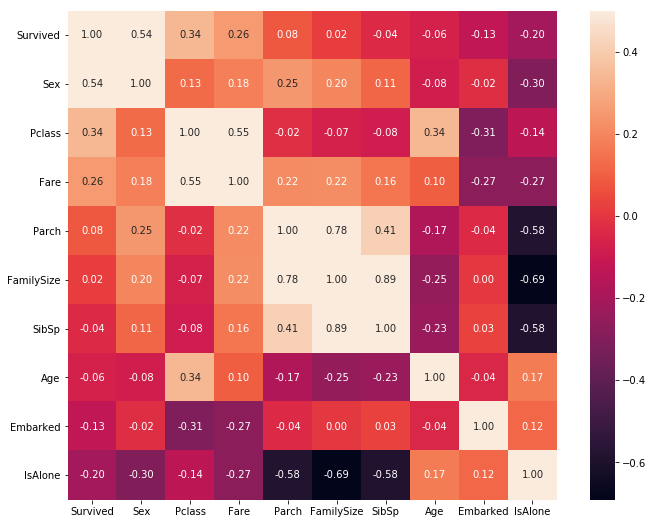

In [109]:
corrmat = train.corr()
k = 15
cols = corrmat.nlargest(k, 'Survived')['Survived'].index
cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=.8, square=True)

sns.heatmap(cm, cbar=True, annot=True, vmax=.5, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

cols

In [111]:
import keras
from keras.utils.np_utils import to_categorical
# 説明変数と目的変数に分割
y_train = train["Survived"].values

COLUMNS = ['Sex', 'Pclass', 'Fare', 'Parch', 'FamilySize', 'SibSp',
       'Age', 'Embarked', 'IsAlone']
x_train = train[COLUMNS].values

x_test = test[COLUMNS].values



# モデル作成

# 1

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import randint as sp_randint

model = RandomForestClassifier(random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(x_train , y_train, test_size=0.25, random_state=42)
# model.fit(X_train, Y_train)

param_dist = {"max_depth": sp_randint(250, 300),
              "n_estimators": sp_randint(50, 320),
              "max_features": [1, 2],
              "min_samples_split": sp_randint(7, 20),
              "min_samples_leaf": sp_randint(1, 3),
              "bootstrap": [ False],
              "criterion": ["gini", "entropy"]}


# Best Model Parameter:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
model = RandomizedSearchCV( estimator=model,
                                    param_distributions=param_dist,
                                    cv=3,              #CV
                                    n_iter=20,          #interation num
                                    scoring="accuracy", #metrics
                                    n_jobs=1,           #num of core
                                    verbose=1,          
                                    random_state=42)

model.fit(X_train, Y_train)
forest_random_best = model.best_estimator_ #best estimator
print("Best Model Parameter: ",model.best_params_)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# MSE
from sklearn.metrics import mean_squared_error
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(Y_train, y_train_pred), mean_squared_error(Y_test, y_test_pred)) )
# R^2
from sklearn.metrics import r2_score
print('MSE train : %.3f, test : %.3f' % (r2_score(Y_train, y_train_pred), r2_score(Y_test, y_test_pred)) )
y_preds = model.predict(X_test)
print(accuracy_score(Y_test, y_preds))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    8.4s finished


Best Model Parameter:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 251, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 241}
MSE train : 0.094, test : 0.184
MSE train : 0.599, test : 0.233
0.8161434977578476


# 2

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier



model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=51, n_jobs=4,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

X_train, X_test, Y_train, Y_test = train_test_split(x_train , y_train, test_size=0.5, random_state=42)
model.fit(X_train, Y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# MSE
from sklearn.metrics import mean_squared_error
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(Y_train, y_train_pred), mean_squared_error(Y_test, y_test_pred)) )
# R^2
from sklearn.metrics import r2_score
print('MSE train : %.3f, test : %.3f' % (r2_score(Y_train, y_train_pred), r2_score(Y_test, y_test_pred)) )
y_preds = model.predict(X_test)
print(accuracy_score(Y_test, y_preds))

# model.fit(x_train, y_train)


MSE train : 0.126, test : 0.177
MSE train : 0.458, test : 0.263
0.8228699551569507


# Submission用のデータ出力

In [125]:
predictions = model.predict(x_test)

# テスト値を再読み込みして，SVMでクラス分類したカラムを追加
df_out = pd.read_csv("./data/titanic/test.csv")
df_out["Survived"] = np.round(predictions).astype(np.int)

# outputディレクトリに出力する
df_out[["PassengerId","Survived"]].to_csv("submission.csv",index=False)